# Plot ASTE SST field

A simple script to show the time mean SST field from ASTE on an orthographic projection, and highlight metadata extracted to xarray.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import cartopy as cart
import cartopy.crs as ccrs
import xmitgcm
from matplotlib import cm, colors

## 1. Read the 3D state and compute time mean

In [2]:
data_dir = '../single_timestep/aste_270x450x180/'
grid_dir = '../grids/aste_270x450x180/'

In [3]:
astemd = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)

In [4]:
astemd

{'has_faces': True,
 'ny': 1350,
 'nx': 270,
 'ny_facets': [450, 0, 270, 180, 450],
 'pad_before_y': [90, 0, 0, 0, 0],
 'pad_after_y': [0, 0, 0, 90, 90],
 'face_facets': [0, 0, 2, 3, 4, 4],
 'facet_orders': ['C', 'C', 'C', 'F', 'F'],
 'face_offsets': [0, 1, 0, 0, 0, 1],
 'transpose_face': [False, False, False, True, True, True]}

In [5]:
ds = xmitgcm.open_mdsdataset(data_dir=data_dir, 
                             prefix=['state_3d_set1'], 
                             geometry='llc', nx=270,
                             read_grid=True,
                             grid_dir=grid_dir, 
                             extra_metadata=astemd,
                             delta_t=1200, 
                             ref_date="2002-1-1 0:0:0")
ds

/Users/tim/work/xmitgcm/xmitgcm/mds_store.py:849: UserWarning: Couldn't find available_diagnostics.log in ../single_timestep/aste_270x450x180/ or ../grids/aste_270x450x180/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


<xarray.Dataset>
Dimensions:    (face: 6, i: 270, i_g: 270, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 1)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * face       (face) int64 0 1 2 3 4 5
    iter       (time) int64 2232
  * time       (time) datetime64[ns] 2002-02-01
    XC         (face, j, i) >f8 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    YC         

In [6]:
sst = ds.THETA.isel(k=0).mean('time')
sst

<xarray.DataArray 'THETA' (face: 6, j: 270, i: 270)>
dask.array<shape=(6, 270, 270), dtype=float32, chunksize=(1, 270, 270)>
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
    k          int64 0
  * face       (face) int64 0 1 2 3 4 5
    XC         (face, j, i) >f8 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    YC         (face, j, i) >f8 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    CS         (face, j, i) >f8 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    SN         (face, j, i) >f8 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    Z          >f8 -5.0
    rA         (face, j, i) >f8 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    Depth      (face, j, i) >f8 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    drF        >f8 10.0
    PHrefC     >f8 49.05
    hFacC      (face, j, i) >f8 da

In [7]:
dict_plt_temp = {'figsize': [10, 10], 'vmin': -2,'vmax': 30,
                               'contours': np.arange(-2,32,2),
                               'cmap': cm.YlOrRd, 'cbarsize': 0.8,
                               'title': 'THETA'}

## Make ASTE plot from scratch with cartopy and matplotlib functions

Note that this does not do any interpolation or filling between faces, so there are missing values between faces.

See also Raphael's repo [MITgcm-recipes](https://github.com/raphaeldussin/MITgcm-recipes) 
which has many plotting routines useful for ASTE.
These could be adapted to the ecco_v4_py infrastructure.

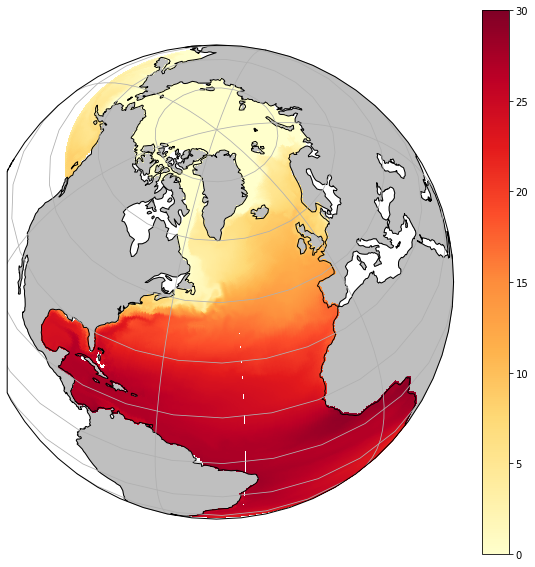

In [13]:
plt.figure(figsize=(10,10))
norm = colors.Normalize(vmin=0,vmax=30)

m = plt.axes(projection=ccrs.Orthographic(central_longitude=-45,central_latitude=50))
for ff in sst.face:
    C=m.pcolormesh(sst.XC[ff],sst.YC[ff],
                   np.ma.masked_values(sst.sel(face=ff),0),
                   norm=norm, 
                   cmap='YlOrRd',
                   transform=ccrs.PlateCarree())
    
m.coastlines()
m.add_feature(cart.feature.LAND,facecolor='0.75')
g1=m.gridlines(draw_labels=False)
plt.colorbar(C,norm=norm)
plt.show()